## Dependencies

In [1]:
from tweet_utility_scripts import *
from transformers import TFBertModel, BertConfig
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
database_base_path = '/kaggle/input/tweet-dataset-split-bert-base-uncased-128/'
hold_out = pd.read_csv(database_base_path + 'hold-out.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']
display(hold_out.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-bert-base-uncased-128/hold_out.tar.gz

base_data_path = 'hold_out/'
x_train = np.load(base_data_path + 'x_train.npy')
y_train = np.load(base_data_path + 'y_train.npy')
x_valid = np.load(base_data_path + 'x_valid.npy')
y_valid = np.load(base_data_path + 'y_valid.npy')

# Delete data dir
shutil.rmtree(base_data_path)

,textID,text,selected_text,sentiment,text_len,selected_text_len,set
0,69a4e7a6f5,"ouch, i'm sorry then",sorry,negative,21,5,train
1,8022534fc2,"thankyou, yes. off to a pre-wedding party now.","Thankyou,",positive,47,9,train
2,f7beb13214,this is how we do itttt,this is how we do itttt,neutral,23,23,train
3,89cdcbfb73,everyone's abandoning the office... i still ha...,everyone's abandoning the office... I still ha...,neutral,62,62,train
4,29a4bb11d9,"acquiring a centos live cd, now where did i pu...",I would like to boot from that. I wonder if I ...,neutral,126,61,train


hold_out/
hold_out/x_train.npy
hold_out/y_valid.npy
hold_out/y_train.npy
hold_out/x_valid.npy


# Model parameters

In [3]:
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 3e-5
ES_PATIENCE = 2

tokenizer_path = database_base_path + 'vocab.txt'
base_path = '/kaggle/input/qa-transformers/bert/'
base_model_path = base_path + 'bert-base-uncased-tf_model.h5'
config_path = base_path + 'bert-base-uncased-config.json'
model_path = 'model.h5'
log_path = './'

# Model

In [4]:
module_config = BertConfig.from_pretrained(config_path, output_hidden_states=True)

def model_fn():
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    token_type_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='token_type_ids')
    
    base_model = TFBertModel.from_pretrained(base_model_path, config=module_config, name="base_model")
    sequence_output, pooled_output, hidden_states = base_model({'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids})
    
    h12 = hidden_states[-1][:, 0]
    h11 = hidden_states[-2][:, 0]
    
    x = Concatenate()([h12, h11])
    x = Dropout(0.1)(x)
    
    y_start = Dense(MAX_LEN, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02), 
                    activation='softmax', name='y_start')(x)
    y_end = Dense(MAX_LEN, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02), 
                  activation='softmax', name='y_end')(x)
    
    model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=[y_start, y_end])
    model.compile(optimizers.Adam(lr=LEARNING_RATE), 
                  loss=losses.CategoricalCrossentropy(), 
                  metrics=[metrics.CategoricalAccuracy()])
    
    return model

model = model_fn()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
base_model (TFBertModel)        ((None, 128, 768), ( 109482240   attention_mask[0][0]             
                                                                 input_ids[0][0]              

# Train

In [5]:
tb_callback = TensorBoard(log_dir=log_path)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, 
                   restore_best_weights=True, verbose=1)

history = model.fit(list(x_train), list(y_train),
                    validation_data=(list(x_valid), list(y_valid)),
                    callbacks=[es, tb_callback],
                    epochs=EPOCHS, 
                    verbose=2).history

model.save_weights(model_path)

Train on 21988 samples, validate on 5497 samples
Epoch 1/3
21988/21988 - 379s - loss: 3.0737 - y_start_loss: 1.3507 - y_end_loss: 1.7246 - y_start_categorical_accuracy: 0.1890 - y_end_categorical_accuracy: 0.0316 - val_loss: 2.8881 - val_y_start_loss: 1.2610 - val_y_end_loss: 1.6272 - val_y_start_categorical_accuracy: 0.1901 - val_y_end_categorical_accuracy: 0.0455
Epoch 2/3
21988/21988 - 357s - loss: 2.7359 - y_start_loss: 1.1907 - y_end_loss: 1.5460 - y_start_categorical_accuracy: 0.1940 - y_end_categorical_accuracy: 0.0621 - val_loss: 2.7425 - val_y_start_loss: 1.1969 - val_y_end_loss: 1.5457 - val_y_start_categorical_accuracy: 0.1941 - val_y_end_categorical_accuracy: 0.0813
Epoch 3/3
21988/21988 - 357s - loss: 2.5152 - y_start_loss: 1.0828 - y_end_loss: 1.4327 - y_start_categorical_accuracy: 0.2093 - y_end_categorical_accuracy: 0.0938 - val_loss: 2.5199 - val_y_start_loss: 1.0801 - val_y_end_loss: 1.4397 - val_y_start_categorical_accuracy: 0.2036 - val_y_end_categorical_accuracy: 0

In [6]:
# Compress logs dir
!tar -cvzf train.tar.gz train
!tar -cvzf validation.tar.gz validation

# Delete logs dir
if os.path.exists('/kaggle/working/train/'):
    shutil.rmtree('/kaggle/working/train/')
if os.path.exists('/kaggle/working/validation/'):
    shutil.rmtree('/kaggle/working/validation/')

train/
train/events.out.tfevents.1586268313.19c98d3a1838.profile-empty
train/events.out.tfevents.1586268293.19c98d3a1838.13.10729.v2
train/plugins/
train/plugins/profile/
train/plugins/profile/2020-04-07_14-05-13/
train/plugins/profile/2020-04-07_14-05-13/local.trace
validation/
validation/events.out.tfevents.1586268673.19c98d3a1838.13.47014.v2


# Model loss graph

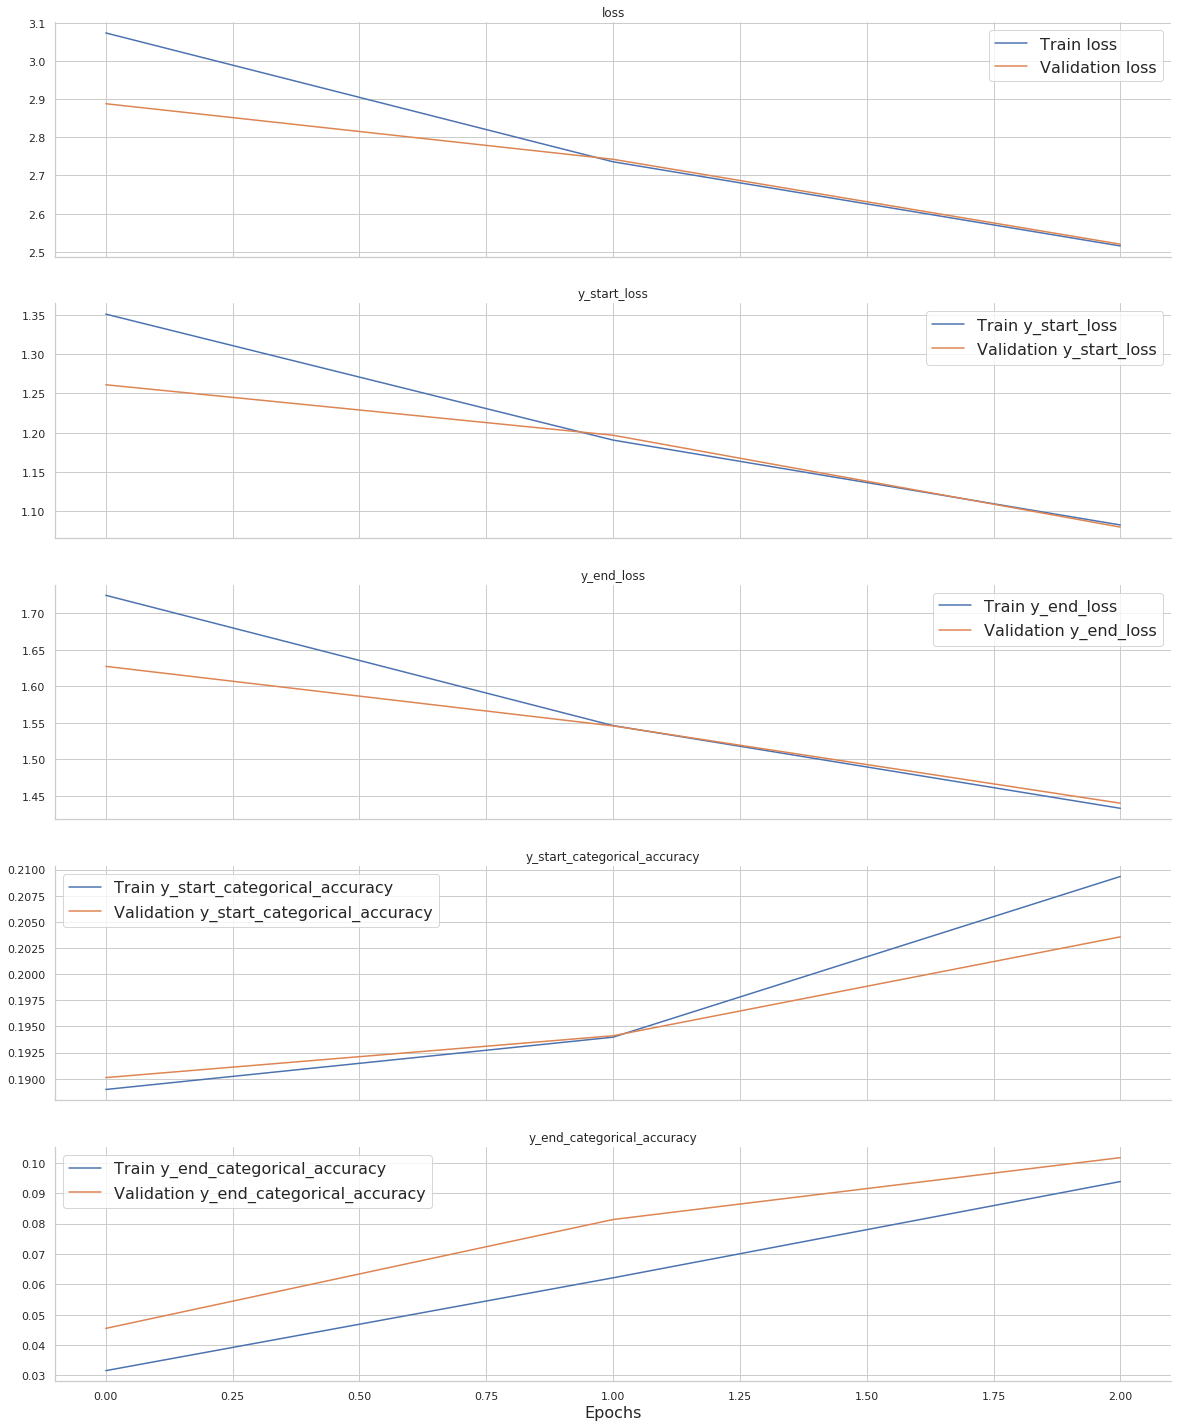

In [7]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'y_start_loss', 'y_end_loss', 'y_start_categorical_accuracy', 'y_end_categorical_accuracy'])

# Tokenizer

In [8]:
tokenizer = BertWordPieceTokenizer(tokenizer_path , lowercase=True)

# Model evaluation

In [9]:
train_preds = model.predict(list(x_train))
valid_preds = model.predict(list(x_valid))

train['start'] = train_preds[0].argmax(axis=-1)
train['end'] = train_preds[1].argmax(axis=-1)
train['prediction'] = train.apply(lambda x: decode(x['start'], x['end'], x['text'], tokenizer), axis=1)
train["prediction"] = train["prediction"].apply(lambda x: '.' if x.strip() == '' else x)

validation['start'] = valid_preds[0].argmax(axis=-1)
validation['end'] = valid_preds[1].argmax(axis=-1)
validation['prediction'] = validation.apply(lambda x: decode(x['start'], x['end'], x['text'], tokenizer), axis=1)
validation["prediction"] = validation["prediction"].apply(lambda x: '.' if x.strip() == '' else x)
  
display(evaluate_model(train, validation))

,Train,Validation,Train samples,Validation samples
Metric/Jaccard,,,,
Overall,0.363596,0.338272,21988,5497
Sentiment negative,0.327658,0.287400,6142,1644
Sentiment positive,0.320524,0.282201,6948,1634
Sentiment neutral,0.422036,0.417250,8898,2219
0 <= text < 50,0.556666,0.525073,7968,1998
50 <= text < 100,0.298540,0.272876,8816,2186
100 <= text < 150,0.178120,0.163140,5195,1311
150 <= text < 200,0.218519,0.000000,9,2
0 <= selected text < 50,0.404600,0.375450,15902,3947


# Visualize predictions

In [10]:
print('Train set')
display(train.head(10))

print('Validation set')
display(validation.head(10))

Train set


,textID,text,selected_text,sentiment,text_len,selected_text_len,set,start,end,prediction,jaccard
0,69a4e7a6f5,"ouch, i'm sorry then",sorry,negative,21,5,train,1,5,"ouch, i'",0.000000
1,8022534fc2,"thankyou, yes. off to a pre-wedding party now.","Thankyou,",positive,47,9,train,1,2,thankyou,0.000000
2,f7beb13214,this is how we do itttt,this is how we do itttt,neutral,23,23,train,1,7,this is how we do ittt,0.714286
3,89cdcbfb73,everyone's abandoning the office... i still ha...,everyone's abandoning the office... I still ha...,neutral,62,62,train,1,4,everyone's abandoning,0.181818
4,29a4bb11d9,"acquiring a centos live cd, now where did i pu...",I would like to boot from that. I wonder if I ...,neutral,126,61,train,1,4,acquiring a centos,0.000000
5,b456369c87,alough i will hold you to your word now for w...,Alough I will hold you to your word now for wh...,neutral,61,60,train,1,4,alough i will,0.230769
6,4e815dd602,im not at litle oven tonight,im not at litle oven tonight,neutral,29,28,train,1,7,im not at litle oven tonight,1.000000
7,3ef24ff6fa,tgif. i don't feel good.,don't feel good.,negative,24,16,train,1,5,tgif. i,0.000000
8,f3b0e2db98,"twenty20 cricket, beer and sunshine very good....","Twenty20 cricket, beer and sunshine very good....",positive,93,93,train,1,7,"twenty20 cricket, beer and sunshine very",0.400000
9,bb97edb997,"off to bed, night every onee","off to bed, night every onee",neutral,28,28,train,1,7,"off to bed, night every one",0.714286


Validation set


,textID,text,selected_text,sentiment,text_len,selected_text_len,set,start,end,prediction,jaccard
21988,e45d640ba0,is sooo stressed about everything i have to do,is sooo stressed about everything I have to do,negative,46,46,validation,4,4,stressed,0.111111
21989,dfa0d5ca14,i just dyededed my hair,I just dyededed my hair,neutral,23,23,validation,1,5,i just dyededed my,0.800000
21990,051f106b59,at the pub with the dog but seems to have misp...,At the pub with the dog but seems to have misp...,neutral,70,70,validation,1,11,at the pub with the dog but seems to have mis,0.692308
21991,4c1897aa51,"ugh, still sick. this calgary cold has lasted ...","Ugh, still sick. This Calgary cold has lasted ...",negative,54,54,validation,1,5,"ugh, still sick",0.200000
21992,daf57be394,"rt #barcampbkk3 for entertainment at night, b...",enjoy,positive,123,5,validation,18,20,.. there,0.000000
21993,1381ed35a5,"you two are hilaaaaarious, i love it. vernae...","you two are hilaaaaarious, I love it.",positive,69,37,validation,1,11,"you two are hilaaaaarious, i love",0.857143
21994,424754c08d,_iain well my team couldn't,_iain well my team couldn't,neutral,27,27,validation,1,5,_iain well my team,0.800000
21995,981713769d,gotta drop off some car parts for a buddy to p...,Gotta drop off some car parts for a buddy to p...,neutral,103,103,validation,1,4,gotta drop off some,0.250000
21996,8aef9288d8,just read up on your mom hope she's okay!!,Hope she's okay!,positive,45,16,validation,1,7,just read up on your mom hope,0.111111
21997,db5005c4d5,that's sad. trauma... future serial killer...,s sad,negative,47,5,validation,1,5,that's sad.,0.000000
